## Segment a sparse 3D image with a single material component  

The goal of this notebook is to develop a 3D segmentation algorithm that improves segmentation where features are detected.

**Data:** AM parts from Xuan Zhang. 

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import os
import h5py
import sys
import time
import seaborn as sns
import pandas as pd

from tomo_encoders import Patches
from params import model_path, get_model_params
from datasets import dataset_names, get_datasets
from tomo_encoders.rw_utils.data_pairs import load_dataset_pairs
from tomo_encoders.neural_nets.surface_segmenter import SurfaceSegmenter
from tomo_encoders.misc import viewer
from tomo_encoders import DataFile
from tomo_encoders.misc.img_stats import calc_jac_acc

In [2]:
model_tag = "M_a07"
model_names = {"segmenter" : "segmenter_Unet_%s"%model_tag}
model_params = get_model_params(model_tag)


 ####################################################### 


Model is M_a07
n_filters [8, 16]
n_blocks 2
activation lrelu
batch_norm True
isconcat [True, True]
pool_size [2, 4]


In [3]:
fe = SurfaceSegmenter(model_initialization = 'load-model', \
                     model_names = model_names, \
                     model_path = model_path)    
# fe.test_speeds(128,n_reps = 5, input_size = (32,32,32))

In [ ]:
fpath_x = '/data02/MyArchive/aisteer_3Dencoders/tmp_data/test_x'
fpath_y = '/data02/MyArchive/aisteer_3Dencoders/tmp_data/test_y'
ds_x = DataFile(fpath_x, tiff = True)
ds_y = DataFile(fpath_y, tiff = True)
vx = ds_x.read_full()
vy = ds_y.read_full()


##################################################
Found existing tiff folder: test_x
Dataset shape: (896, 2176, 2176)

##################################################
Found existing tiff folder: test_y
Dataset shape: (896, 2176, 2176)


In [ ]:
iter_list = [(32,256), (64,256), (128,4)]

In [6]:
min_max = vx[::4,::4,::4].min(), vx[::4,::4,::4].max()
for iter_item in iter_list:
    psize, bsize = iter_item
    print("\n")
    print(f"psize: {psize}; bsize: {bsize}")
    t00 = time.time()
    p_sel = Patches(vx.shape, initialize_by='regular-grid', patch_size = tuple([psize]*3))
    vp = np.zeros(vx.shape, dtype = np.uint8)
    x = p_sel.extract(vx, tuple([psize]*3))
    x = fe.predict_patches("segmenter", \
                           x[...,np.newaxis], \
                           bsize, None, min_max = min_max)[...,0]
    print(f"input: {x.shape}")
    p_sel.fill_patches_in_volume(x, vp)
    t11 = time.time()
    print(f"time for segmentation: {(t11 - t00):.2f} seconds")
    print(f"IoU accuracy w.r.t ref. GT: {calc_jac_acc(vy, vp):.5f}")
    
    break
    
#     if psize == 32:
#         fpath_p = '/data02/MyArchive/aisteer_3Dencoders/tmp_data/test_y'
#         ds_pred = DataFile(fpath_p, tiff = True, d_type = np.uint8, d_shape = vp.shape)
#         ds_pred.create_new(overwrite=True)
#         ds_pred.write_full(vp)
#         break



psize: 32; bsize: 256
input: (129472, 32, 32, 32)
time for segmentation: 183.83 seconds
IoU accuracy w.r.t ref. GT: 0.94733


In [7]:
imx = viewer.get_orthoplanes(vol = vx)
imp = viewer.get_orthoplanes(vol = vp)
imy = viewer.get_orthoplanes(vol = vy)

In [8]:
s = (slice(300,-200), slice(300,-200))

<AxesSubplot:>

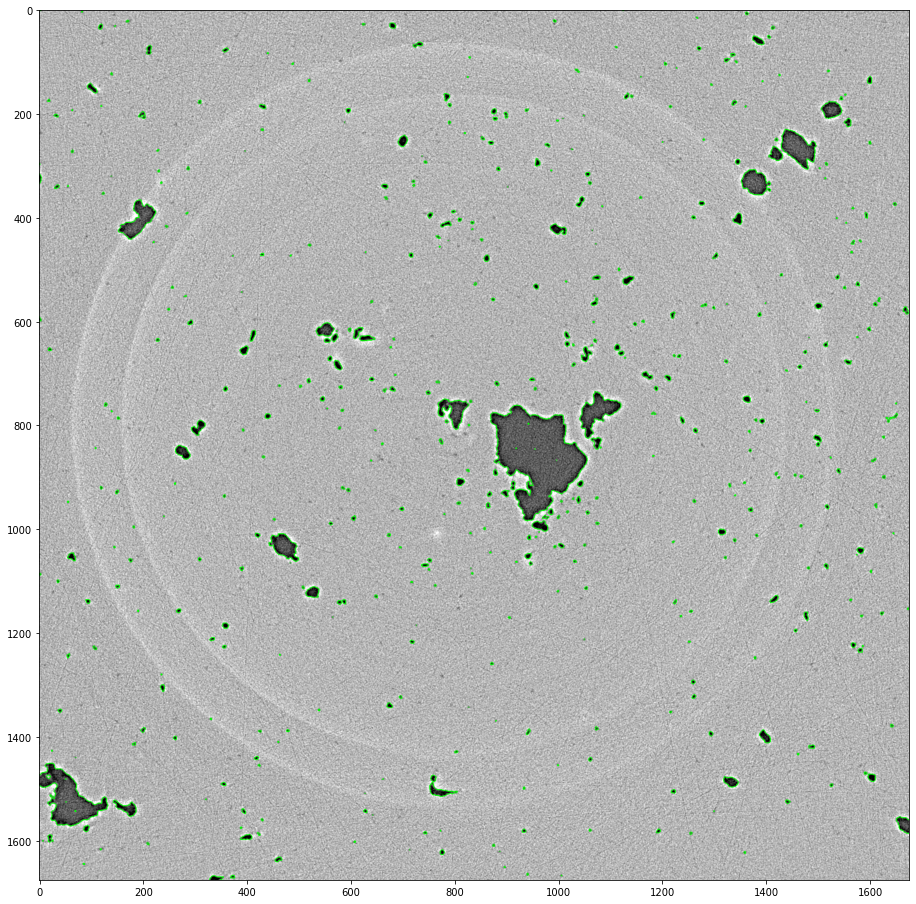

In [10]:
fig, ax = plt.subplots(1,1,figsize = (16,16))
viewer.edge_plot(imx[0][s], imp[0][s], ax)
# ax.imshow(np.sqrt((imy[0][s]-imp[0][s])**2), cmap = 'copper', alpha = 0.5)

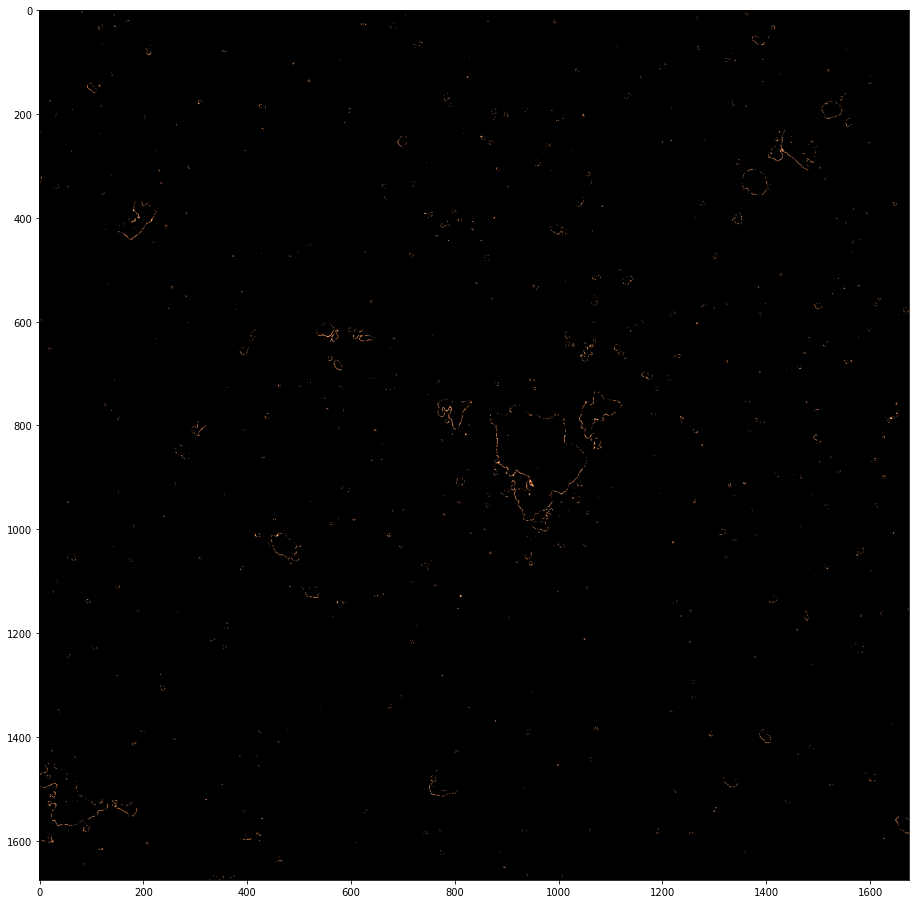

In [10]:
err_img = np.sqrt((imy[0][s]-imp[0][s])**2)
fig, ax = plt.subplots(1,1,figsize = (16,16))
ax.imshow(err_img, cmap = 'copper')

In [11]:
def make_binary_structure(radius, ndim = 3):
    struct_size = 2*radius + 1
    struct = np.ones(tuple([struct_size]*ndim))

    r = np.arange(-radius, radius + 1)

    yy, xx = np.meshgrid(r, r, indexing = 'ij')
    dist = np.sqrt(yy**2 + xx**2)
    struct[dist > radius] = 0
    return struct
from scipy.ndimage import binary_erosion, binary_dilation

incorrect pixels: 4570
incorrect pixels: 18


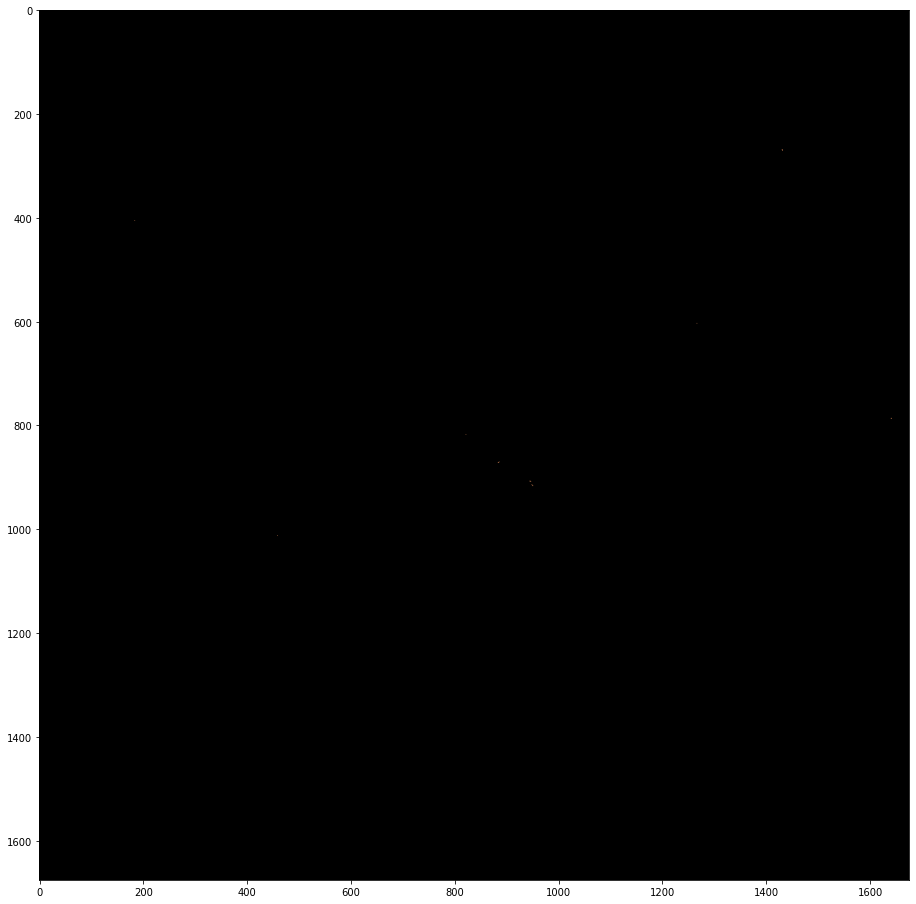

In [12]:
err_img = np.sqrt((imy[0][s]-imp[0][s])**2).astype(np.uint8)
print(f"incorrect pixels: {err_img.sum()}")
struct = make_binary_structure(1, ndim = 2)
err_img = binary_erosion(err_img, structure = struct)
print(f"incorrect pixels: {err_img.sum()}")
fig, ax = plt.subplots(1,1,figsize = (16,16))
ax.imshow(err_img, cmap = 'copper')